In [1]:
import gymnasium as gym
import numpy as np
from gymnasium.utils import seeding
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from time import sleep
from IPython import display 
from IPython.display import clear_output
import os

In [3]:
path = os.getcwd()

In [4]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
env = gym.make('Taxi-v3',render_mode="ansi")
print(env.reset(seed=217))
init_state , info = env.reset(seed=217)
#print(init_state)

(427, {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 0], dtype=int8)})


In [6]:
num_states = env.observation_space.n
num_actions = env.action_space.n

print(color.BOLD  + f"Number of states: {num_states}")
print(color.BOLD + f"Number of actions: {num_actions}")

Number of states: 500
Number of actions: 6


## Stability and Convergence plotting functions

In [7]:
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.autolayout"] = True
fontdict = {'fontsize': 13,'fontweight': "bold"}
bbox = dict(facecolor='red', edgecolor='black',alpha = 0.3)

In [8]:
def plot_stability(name,x,y,fontdict,bbox,l,w,list1,list2,list3):

    fig , ax = plt.subplots(1,3,figsize = (18,8))
    ax = ax.flatten()
    mean1 = []
    mean2 = []
    mean3 = []
    mean = np.zeros((3,))
    for i in range(3):
        mean[i] = np.mean(y[i,:])
    for i in range(len(X[0])):
        mean1.append(mean[0])
        mean2.append(mean[1])
        mean3.append(mean[2])
    ax[0].plot(x[0,:],y[0,:],'b-')
    ax[0].plot(x[0,:],mean1,'r--',label = 'Mean')
    ax[1].plot(x[1,:],y[1,:],'b-')
    ax[1].plot(x[1,:],mean2,'r--',label = 'Mean')
    ax[2].plot(x[2,:],y[2,:],'b-')
    ax[2].plot(x[2,:],mean3,'r--',label = 'Mean')
    ax[0].text(l[0], w[0], "Gamma = 0.6\n(Decaying Epsilon)", fontsize=12, bbox=bbox)
    ax[1].text(l[1], w[1], "Gamma = 0.8\n(Decaying Epsilon)", fontsize=12, bbox=bbox)
    ax[2].text(l[2], w[2], "Gamma = 0.99\n(Decaying Epsilon)", fontsize=12, bbox=bbox)
    fig.suptitle(name, fontsize=15,fontweight="bold")
    fig.subplots_adjust(hspace=0.4, top=0.9)
    axes = [0,1,2]
    ax[0].set_ylim(list1)
    ax[1].set_ylim(list2)
    ax[2].set_ylim(list3)
    for item in axes:
        ax[item].legend()
        ax[item].set_xlabel('Training number',fontdict = fontdict)
        ax[item].set_ylabel('Average Reward (per train)',fontdict = fontdict)
        ax[item].set_xlim([1,10])

    plt.show()

In [9]:
def plot_convergence(name,x,y,fontdict,bbox,l,w):
    fig , ax = plt.subplots(1,3,figsize = (18,8))
    ax = ax.flatten()
    axes = [0, 1,2]
    ax[0].plot(x[0,:],y[0,:],'b-')
    ax[1].plot(x[1,:],y[1,:],'b-')
    ax[2].plot(x[2,:],y[2,:],'b-')
    fig.suptitle(name, fontsize=15,fontweight="bold")
    fig.subplots_adjust(hspace=0.4, top=0.9)
    ax[0].text(l[0], w[0], '$Gamma = 0.6$', fontsize=12, bbox=bbox)
    ax[1].text(l[1], w[1], '$Gamma = 0.8$', fontsize=12, bbox=bbox)
    ax[2].text(l[2], w[2], '$Gamma = 0.99$', fontsize=12, bbox=bbox)
    
    for item in axes:
        ax[item].set_xlabel('Episodes',fontdict = fontdict)
        ax[item].set_ylabel('Mean Reward per Episode',fontdict = fontdict)
        #ax[0].set_ylim([-12,-8])
    plt.show()

# Q-Learning Algorithms

## Q_Learning with decay Epsilon

In [10]:
def QL_decay_eps(alpha,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,num_episodes,max_steps_per_episode):
    
                                                   # The value of alpha is not change but the 
                                                    #value of epsilon changes in this algorithm
    Q = np.zeros((num_states, num_actions))
    count = 0
    tot_rwd = 0
    frames = []
    rewards_plt = np.zeros((num_episodes))
    episodes_plt = np.zeros((num_episodes))

    for episode in range(num_episodes):
        count = count + 1

        tot_rwd_per_episode = 0

        
        state = env.reset()[0]
        
        
        for step in range(max_steps_per_episode):
            
            if np.random.uniform(0, 1) < epsilon:         #In training phase "Epsilon-Greedy Policy" is taken
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])
            
            new_state, reward, done, _, info = env.step(action)
            frames.append({'frame':env.render(),
                          'state': state,
                          'action': action,
                          'reward': reward})
            
            tot_rwd_per_episode += reward

            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

            state = new_state

            if done:
                break
        
        tot_rwd += tot_rwd_per_episode
        
        episodes_plt[episode] = episode
        rewards_plt[episode] = tot_rwd_per_episode
    
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        #if episode % 500 == 0:
         #   print("Epsilon:",epsilon , "Episode :" , episode , "Reward :",reward)

    average_reward = tot_rwd / num_episodes
    columns = ['south','north','east','west','pickup','drop off']
    Q_df = pd.DataFrame(Q,columns = columns)
    return Q_df,frames , average_reward , episodes_plt , rewards_plt

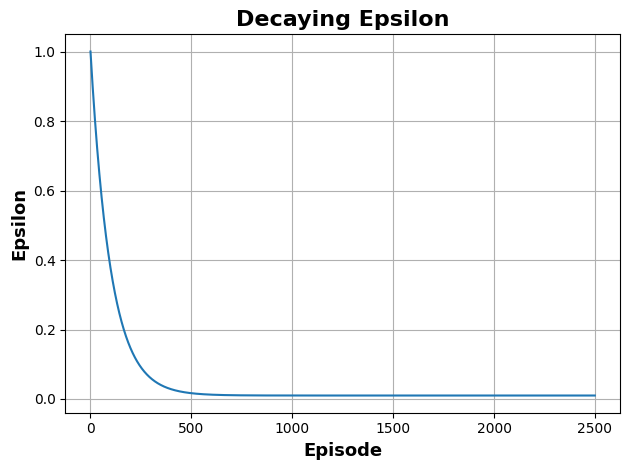

In [11]:
ghh = np.arange(2500)
epss_list = []
for i in range(len(ghh)):
    epsilonn = 0.01 + (1.0 - 0.01) * np.exp(-0.01 * ghh[i])
    epss_list.append(epsilonn)
    
plt.title('Decaying Epsilon',fontdict = fontdict,fontsize = 16)
plt.plot(ghh,epss_list)
plt.ylabel('Epsilon',fontdict = fontdict)
plt.xlabel('Episode',fontdict = fontdict)
plt.show()

## Q_Learning with constant Epsilon

In [12]:
def QL_cst_eps(alpha,gamma,epsilon,num_episodes,max_steps_per_episode):
                                               # The values of epsilon and alpha are not change
                                                    #in this algorithm
    Q = np.zeros((num_states, num_actions))    
    count = 0
    tot_rwd = 0
    frames = []
    rewards_plt = np.zeros((num_episodes))
    episodes_plt = np.zeros((num_episodes))

    for episode in range(num_episodes):
        count = count + 1

        tot_rwd_per_episode = 0

        
        state = env.reset()[0]
        
        
        for step in range(max_steps_per_episode):
            
            if np.random.uniform(0, 1) < epsilon:         #In training phase "Epsilon-Greedy Policy" is taken
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])
            
            new_state, reward, done, _, info = env.step(action)
            frames.append({'frame':env.render(),
                          'state': state,
                          'action': action,
                          'reward': reward})
            
            tot_rwd_per_episode += reward
            
            #Q_table is updated, below:
            
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

            state = new_state

            if done:
                break
        
        tot_rwd += tot_rwd_per_episode
        
        episodes_plt[episode] = episode
        rewards_plt[episode] = tot_rwd_per_episode
    
        #if episode % 500 == 0:
            #print("Epsilon:",epsilon , "Episode :" , episode , "Reward :",reward)

    average_reward = tot_rwd / num_episodes
    columns = ['south','north','east','west','pickup','drop off']
    Q_df = pd.DataFrame(Q,columns = columns)
    
    return Q_df,frames , average_reward , episodes_plt , rewards_plt

## Q_Learning with decay learning rate (alpha)

In [13]:
def QL_decay_lr(alpha,gamma,epsilon,min_alpha,decay_rate,num_episodes,max_steps_per_episode):
                                               # The value of epsilon is not change but the 
                                                    #value of alpha changes in this algorithm
    Q = np.zeros((num_states, num_actions))    
    count = 0
    tot_rwd = 0
    frames = []
    rewards_plt = np.zeros((num_episodes))
    episodes_plt = np.zeros((num_episodes))

    for episode in range(num_episodes):
        count = count + 1

        tot_rwd_per_episode = 0

        
        state = env.reset()[0]
        
        
        for step in range(max_steps_per_episode):
            
            if np.random.uniform(0, 1) < epsilon:         #In training phase "Epsilon-Greedy Policy" is taken
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])
            
            new_state, reward, done, _, info = env.step(action)
            frames.append({'frame':env.render(),
                          'state': state,
                          'action': action,
                          'reward': reward})
            
            tot_rwd_per_episode += reward
            
            #Q_table is updated, below:
            
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

            state = new_state

            if done:
                break
        
        tot_rwd += tot_rwd_per_episode
        
        episodes_plt[episode] = episode
        rewards_plt[episode] = tot_rwd_per_episode
        
        alpha = min_alpha +  0.95 * alpha * np.exp(-decay_rate * episode)     # defining an exponential function
                                                                            #for reducing alpha value 
                                                                                # Parameters: (min_alpha,decay_rate)

    average_reward = tot_rwd / num_episodes
    columns = ['south','north','east','west','pickup','drop off']
    Q_df = pd.DataFrame(Q,columns = columns)
    
    return Q_df,frames , average_reward , episodes_plt , rewards_plt

Text(0.5, 0, 'episode')

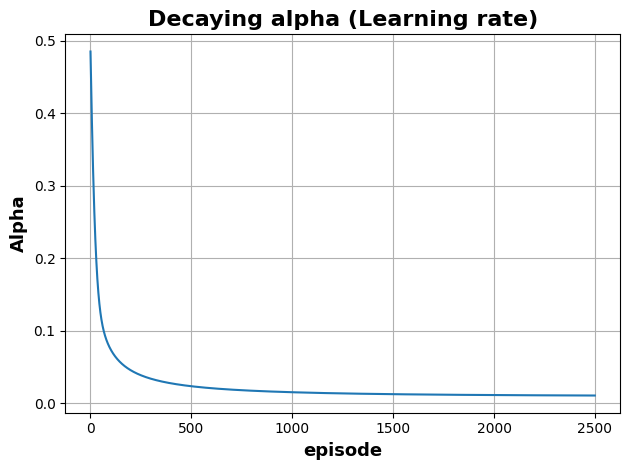

In [14]:
gh = np.arange(2500)
min_alpha = 0.01
alphaa = 0.5
alpha_list = []
for i in range(len(gh)):
    alphaa = min_alpha +  0.95 * alphaa * np.exp(-0.001 * gh[i])
    alpha_list.append(alphaa)
    

#print(alpha_list)
plt.title('Decaying alpha (Learning rate)',fontdict = fontdict,fontsize = 16)
plt.plot(gh,alpha_list)
plt.ylabel('Alpha',fontdict = fontdict)
plt.xlabel('episode',fontdict = fontdict)


# Training

In [15]:
X1 = np.arange(10) + 1
X2 = np.arange(10) + 1
X3 = np.arange(10) + 1
XX = np.vstack((X1,X2))
X = np.vstack((XX,X3)) 

### Number of episodes & maximum steps per episode effect on decay_eps

In [16]:
            #QL_decay_eps(alpha,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,num_episodes,max_steps_per_episode):
episodess = []
rewardss = []

num_episodes = [2000,2500,3000]
max_steps_per_episode = [20,35,50]

count = 0
for episodes in num_episodes:
    for max_step in max_steps_per_episode:
        Q_df_decay_eps,frames_decay_eps , average_reward_decay_eps , episodes_decay_eps , rewards_decay_eps = QL_decay_eps(0.5,0.99,1.0,1.0,0.01,0.01,episodes,max_step)
        episodess.append(episodes_decay_eps)
        rewardss.append(rewards_decay_eps)

        count += 1
#Q_df_decay_eps.to_csv(os.path.join(path,r"Q_table for decaying Epsilon.csv"))    # the last trained Q_table with 
                                                                                #gamma: 0.99 is saved

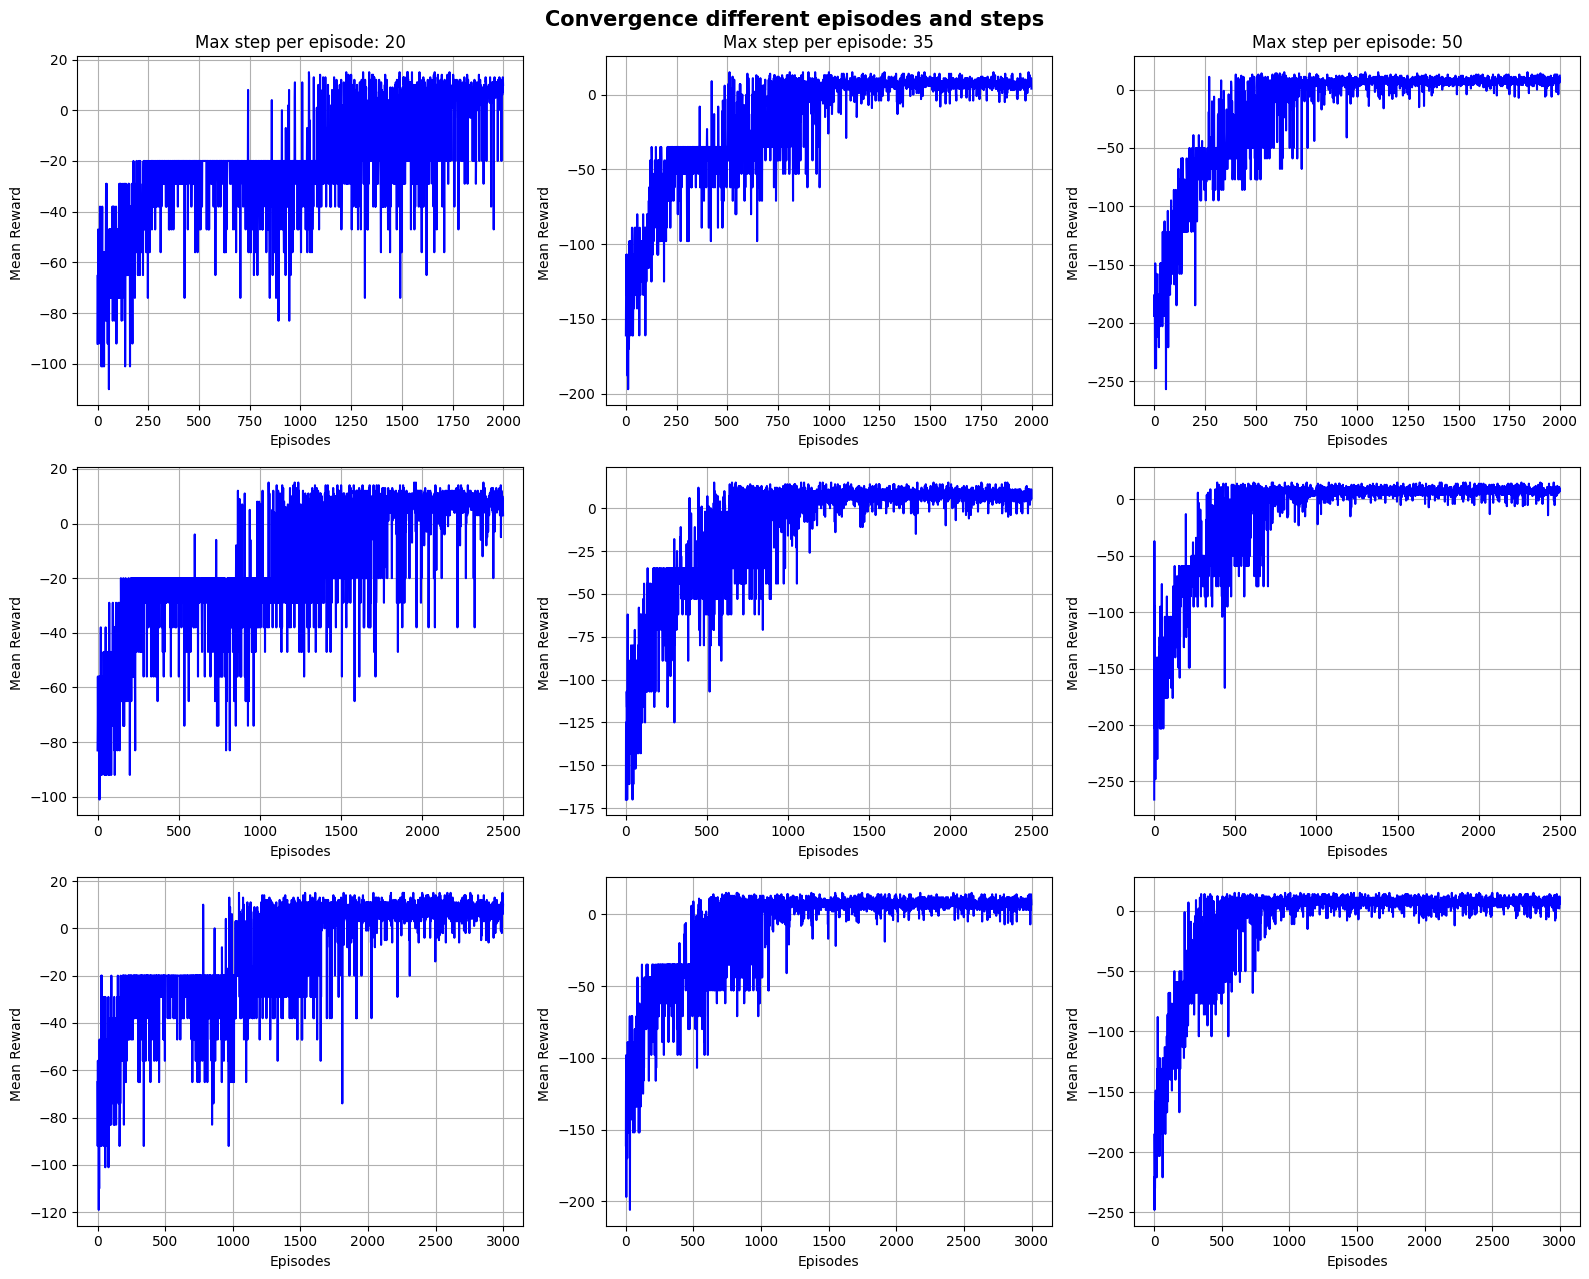

In [17]:
fig , ax = plt.subplots(3,3,figsize = (16,13))
ax = ax.flatten()
fig.suptitle('Convergence different episodes and steps', fontsize=15,fontweight="bold")
fig.subplots_adjust(hspace=0.4, top=0.9)
ax[0].plot(episodess[0],rewardss[0],'b-')
ax[1].plot(episodess[1],rewardss[1],'b-')
ax[2].plot(episodess[2],rewardss[2],'b-')
ax[3].plot(episodess[3],rewardss[3],'b-')
ax[4].plot(episodess[4],rewardss[4],'b-')
ax[5].plot(episodess[5],rewardss[5],'b-')
ax[6].plot(episodess[6],rewardss[6],'b-')
ax[7].plot(episodess[7],rewardss[7],'b-')
ax[8].plot(episodess[8],rewardss[8],'b-')
ax[0].title.set_text('Max step per episode: 20')
ax[1].title.set_text('Max step per episode: 35')
ax[2].title.set_text('Max step per episode: 50')
axes = np.arange(9)
for item in axes:
    ax[item].set_xlabel('Episodes')
    ax[item].set_ylabel('Mean Reward ')
# ax[1].plot(X[0,:],avg_dc_eps_list,'r--',label = 'Mean')    # Denoting line of Mean Value 
# ax[0].legend(loc = 'upper right')
# ax[1].plot(X[1,:],average_cst_rwd,'b-')
# ax[1].plot(X[0,:],avg_cst_eps_list,'r--',label = 'Mean')   # Denoting line of Mean Value 
# ax[1].legend(loc = 'upper right')
# ax[0].text(0, -11.9,"Decaying Epsilon\n(Gamma = 0.8)",fontweight="bold", fontsize=12,bbox = bbox)
# ax[1].text(0, -27.4,"Constant Epsilon\n (Gamma = 0.8)",fontweight="bold", fontsize=12, bbox=bbox)


### Gamma effect on decay_eps

In [18]:
gamma = [0.6,0.8,0.99]     # discount factor (Recommended: 0.6 < gamma <1.0)
average_np = np.zeros((3,10))
episodes_np = np.zeros((3,2500))
rewards_np = np.zeros((3,2500))
        
            #QL_decay_eps(alpha,gamma,epsilon,max_epsilon,min_epsilon,decay_rate,num_episodes,max_steps_per_episode):
count = 0
for item in gamma:
    for i in range(10):
        Q_df_decay_eps,frames_decay_eps , average_reward_decay_eps , episodes_decay_eps , rewards_decay_eps = QL_decay_eps(0.5,item,1.0,1.0,0.01,0.01,2500,50)
        average_np[count,i] = average_reward_decay_eps
    episodes_np[count] = episodes_decay_eps
    rewards_np[count] = rewards_decay_eps
    count += 1
Q_df_decay_eps.to_csv(os.path.join(path,r"Q_table for decaying Epsilon.csv"))    # the last trained Q_table with 
                                                                                #gamma: 0.99 is saved

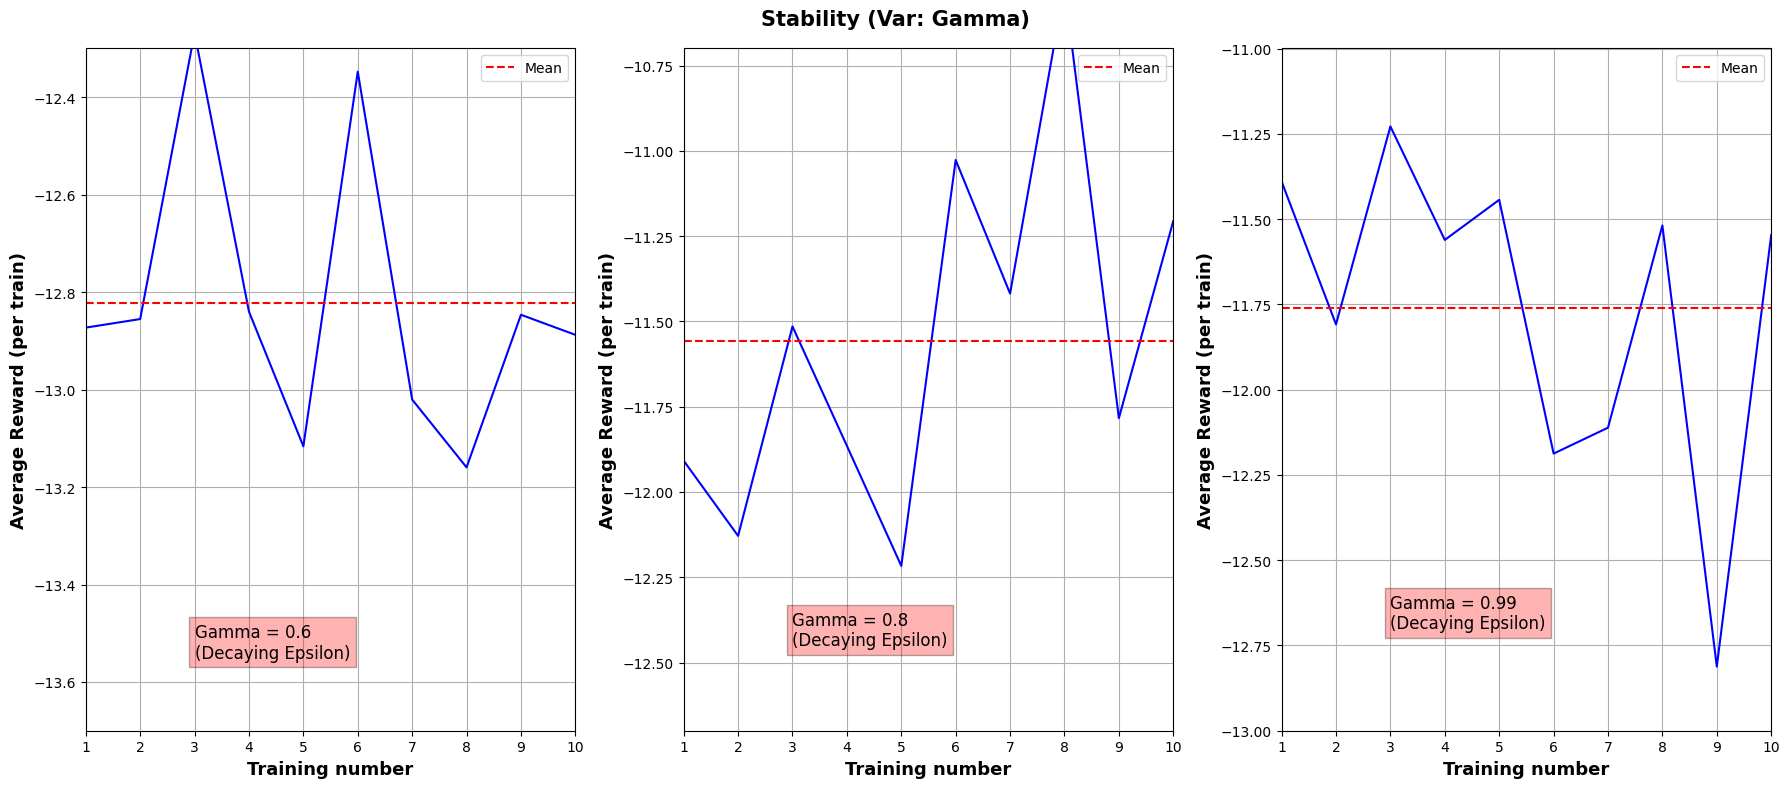

Mean Reward  throughout all tries (for Gamma: 0.6): -12.8214
Mean Reward  throughout all tries (for Gamma: 0.8): -11.55876
Mean Reward  throughout all tries (for Gamma: 0.99):-11.76092


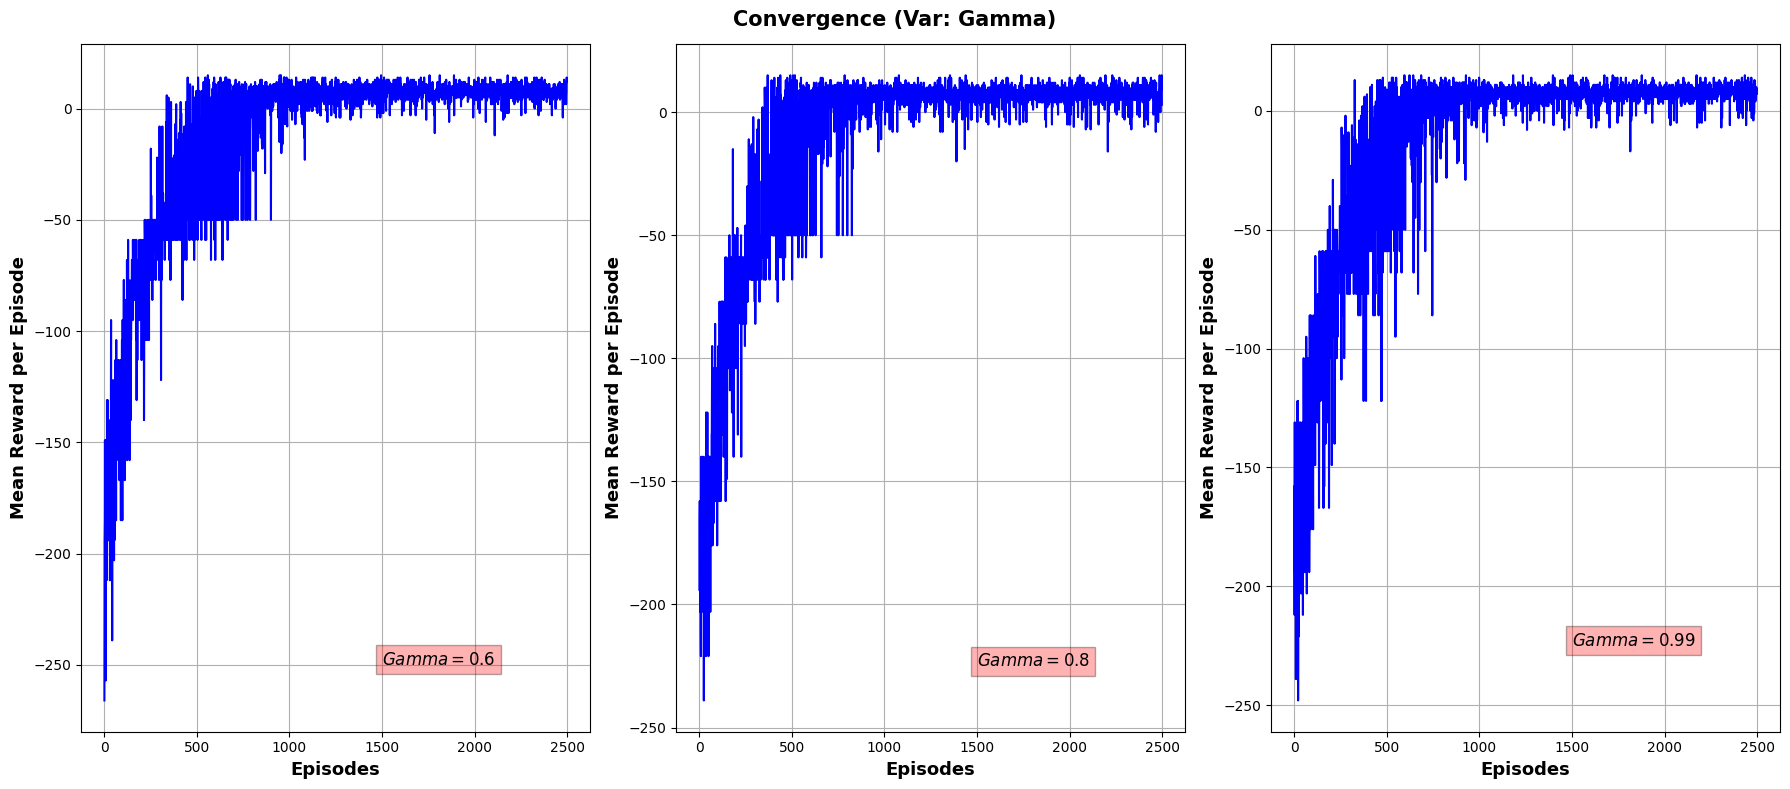

In [45]:
plot_stability('Stability (Var: Gamma)',X,average_np,fontdict,bbox,[3,3,3],[-13.55,-12.45,-12.7],[-13.7,-12.3],[-12.7,-10.7],[-13,-11])
print(color.BOLD + f"Mean Reward  throughout all tries (for Gamma: 0.6): {average_np[0].mean()}")
print(f"Mean Reward  throughout all tries (for Gamma: 0.8): {average_np[1].mean()}")
print(f"Mean Reward  throughout all tries (for Gamma: 0.99):{average_np[2].mean()}" + color.END)
plot_convergence('Convergence (Var: Gamma)',episodes_np,rewards_np,fontdict,bbox,[1500,1500,1500],[-250,-225,-225])

In [20]:
                            #QL_cst_eps(alpha,gamma,epsilon,num_episodes,max_steps_per_episode):
average_cst_rwd = np.zeros((3,10))
# gamma = [0.6,0.8,0.99]     # discount factor (Recommended: 0.6 < gamma <1.0)
episodess_cst_gamma = []
rewardss_cst_gamma = [] 
count = 0

for item in gamma:
    for i in range(10):
        Q_df_cst_eps ,frames_cst_eps , average_reward_cst_eps , episodes_cst_eps , rewards_cst_eps = QL_cst_eps(0.5,item,0.25,2500,50)
        average_cst_rwd[count,i] = average_reward_cst_eps
    episodess_cst_gamma.append(episodes_cst_eps)
    rewardss_cst_gamma.append(rewards_cst_eps)
    count += 1

Q_df_cst_eps.to_csv(os.path.join(path,r"Q_table for constant Epsilon.csv"))    # the last trained Q_table with 
                                                                                #gamma: 0.8 and 
                                                                            #constant epsilon:0.25 is saved


### Comparison of convergence for decaying and coonstant epsilon base on different gammas

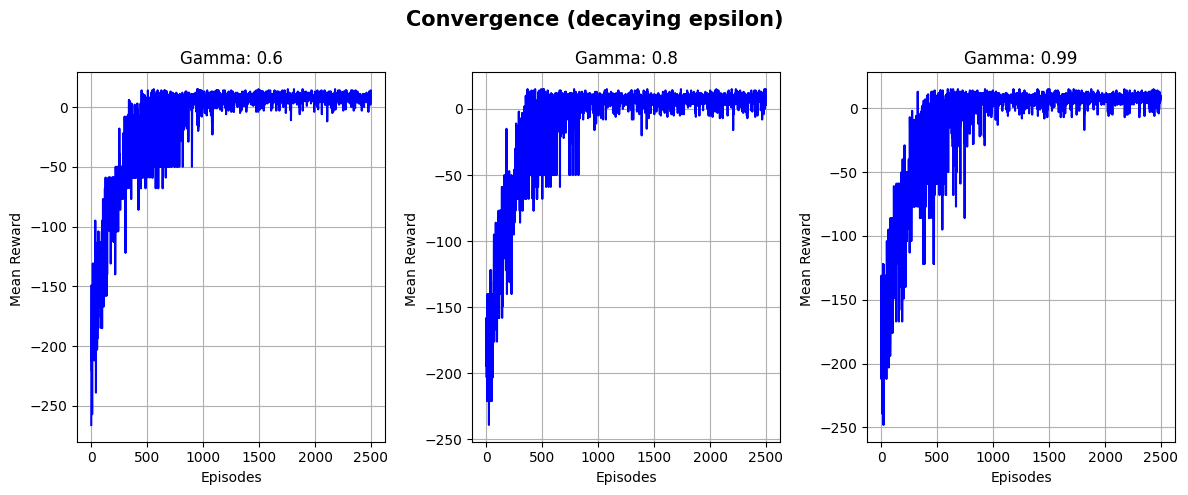

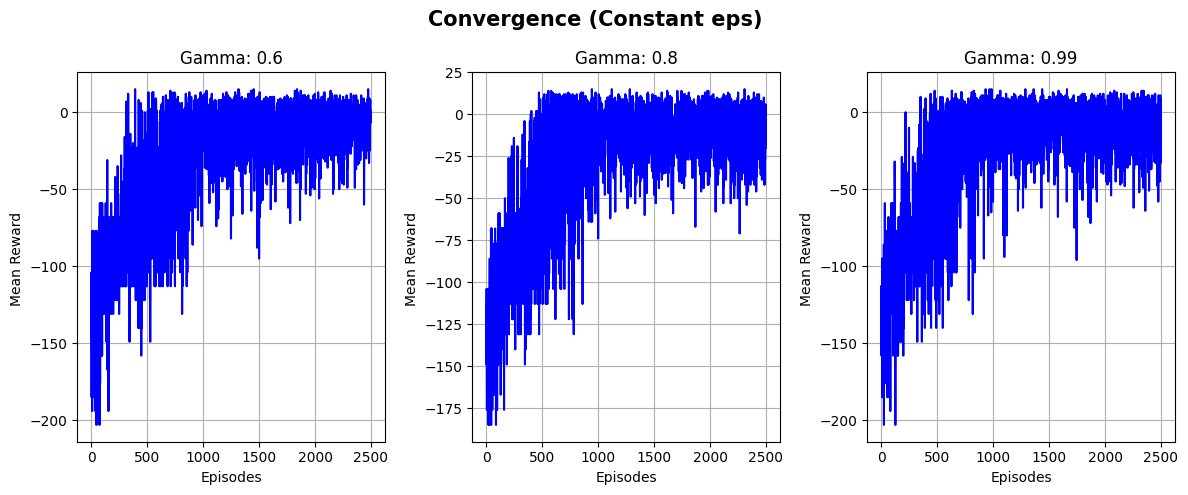

In [21]:
fig , ax = plt.subplots(1,3,figsize = (12,5))
ax = ax.flatten()
fig.suptitle('Convergence (decaying epsilon)', fontsize=15,fontweight="bold")
fig.subplots_adjust(hspace=0.4, top=0.9)
ax[0].plot(episodes_np[0],rewards_np[0],'b-')
ax[1].plot(episodes_np[1],rewards_np[1],'b-')
ax[2].plot(episodes_np[2],rewards_np[2],'b-')
ax[0].title.set_text('Gamma: 0.6')
ax[1].title.set_text('Gamma: 0.8')
ax[2].title.set_text('Gamma: 0.99')
axes = np.arange(3)
for item in axes:
    ax[item].set_xlabel('Episodes')
    ax[item].set_ylabel('Mean Reward ')
plt.show()
fig , ax = plt.subplots(1,3,figsize = (12,5))
ax = ax.flatten()
fig.suptitle('Convergence (Constant eps)', fontsize=15,fontweight="bold")
ax[0].plot(episodess_cst_gamma[0],rewardss_cst_gamma[0],'b-')
ax[1].plot(episodess_cst_gamma[1],rewardss_cst_gamma[1],'b-')
ax[2].plot(episodess_cst_gamma[2],rewardss_cst_gamma[2],'b-')
ax[0].title.set_text('Gamma: 0.6')
ax[1].title.set_text('Gamma: 0.8')
ax[2].title.set_text('Gamma: 0.99')

for item in axes:
    ax[item].set_xlabel('Episodes')
    ax[item].set_ylabel('Mean Reward ')
plt.show()
# ax[1].plot(X[0,:],avg_dc_eps_list,'r--',label = 'Mean')    # Denoting line of Mean Value 
# ax[0].legend(loc = 'upper right')
# ax[1].plot(X[1,:],average_cst_rwd,'b-')
# ax[1].plot(X[0,:],avg_cst_eps_list,'r--',label = 'Mean')   # Denoting line of Mean Value 
# ax[1].legend(loc = 'upper right')
# ax[0].text(0, -11.9,"Decaying Epsilon\n(Gamma = 0.8)",fontweight="bold", fontsize=12,bbox = bbox)
# ax[1].text(0, -27.4,"Constant Epsilon\n (Gamma = 0.8)",fontweight="bold", fontsize=12, bbox=bbox)


In [22]:
avg_cst_eps_list = []
avg_dc_eps_list = []
for i in range(10):
    avg_cst_eps_list.append(average_cst_rwd[2].mean())   # gamma: 0.99
    avg_dc_eps_list.append(average_np[2].mean())

### Comparison of Constant & Decaying Epsilon

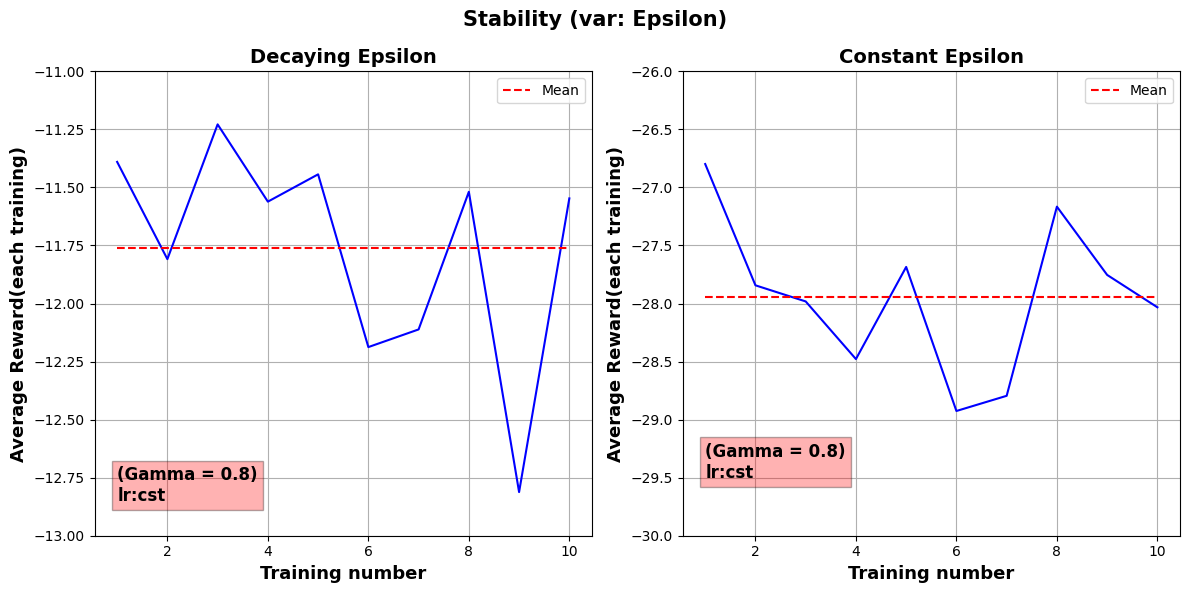


Mean Reward throughout all tries (for Decaying Epsilon): -12.8214
Mean Reward  throughout all tries (for Constant Epsilon):-28.83846666666667


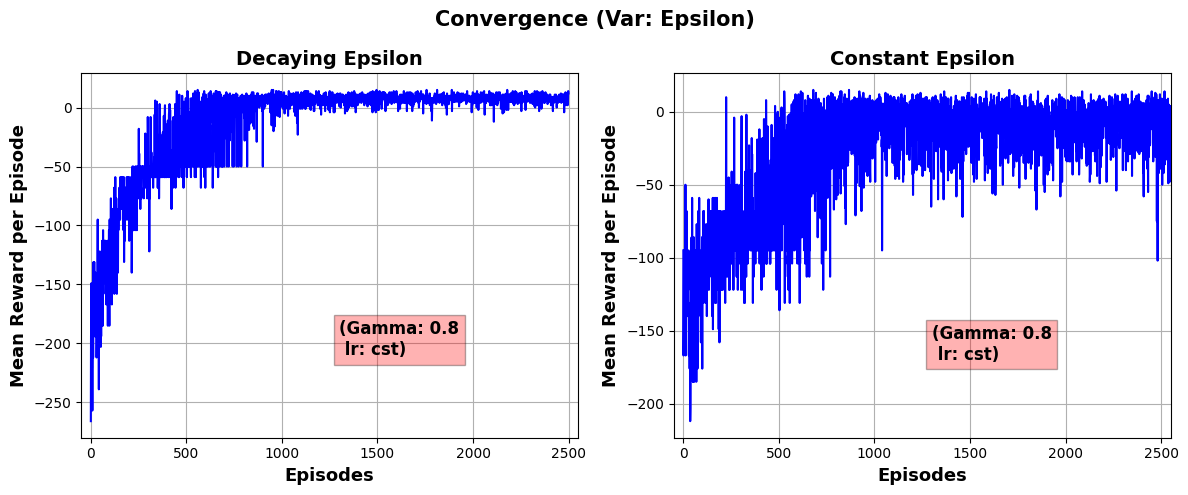

In [56]:
fig , ax = plt.subplots(1,2,figsize = (12,6))
ax = ax.flatten()
ax[0].plot(X[2,:],average_np[2,:],'b-')
ax[0].plot(X[2,:],avg_dc_eps_list,'r--',label = 'Mean')    # Denoting line of Mean Value 
ax[0].set_title('Decaying Epsilon',fontweight="bold",fontsize=14)
ax[0].set_ylim([-13,-11])
ax[1].set_title('Constant Epsilon',fontweight="bold",fontsize=14)
ax[0].legend(loc = 'upper right')
ax[1].plot(X[2,:],average_cst_rwd[2],'b-')
ax[1].plot(X[2,:],avg_cst_eps_list,'r--',label = 'Mean')   # Denoting line of Mean Value 
ax[1].legend(loc = 'upper right')
ax[0].text(1, -12.85,"(Gamma = 0.8)\nlr:cst",fontweight="bold", fontsize=12,bbox = bbox)
ax[1].text(1, -29.5,"(Gamma = 0.8)\nlr:cst",fontweight="bold", fontsize=12, bbox=bbox)
ax[1].set_ylim([-30,-26])
fig.suptitle('Stability (var: Epsilon)', fontsize=15,fontweight="bold")
fig.subplots_adjust(hspace=0.4, top=0.9)

axes = [0,1]
for item in axes:
    ax[item].set_xlabel('Training number',fontdict = fontdict)
    ax[item].set_ylabel('Average Reward(each training)',fontdict = fontdict)

plt.show()
                                          
                                        # Convergence
print(color.BOLD + f"\nMean Reward throughout all tries (for Decaying Epsilon): {average_np[0].mean()}")
print(f"Mean Reward  throughout all tries (for Constant Epsilon):{average_cst_rwd.mean()}" + color.END)

fig , ax = plt.subplots(1,2,figsize = (12,5))
ax = ax.flatten()
ax[0].plot(episodes_np[0],rewards_np[0],'b-')
ax[1].plot(episodes_cst_eps,rewards_cst_eps,'b-')
axes = [0, 1]
ax[0].set_title('Decaying Epsilon',fontweight="bold",fontsize=14)
ax[1].set_title('Constant Epsilon',fontweight="bold",fontsize=14)
fig.suptitle('Convergence (Var: Epsilon)', fontsize=15,fontweight="bold")
fig.subplots_adjust(hspace=0.4, top=0.9)
ax[0].text(1300, -210,'(Gamma: 0.8\n lr: cst)',fontweight="bold", fontsize=12, bbox=bbox)
ax[1].text(1300, -170,'(Gamma: 0.8\n lr: cst)',fontweight="bold", fontsize=12, bbox=bbox)

for item in axes:
    ax[item].set_xlabel('Episodes',fontdict = fontdict)
    ax[item].set_ylabel('Mean Reward per Episode',fontdict = fontdict)
    ax[item].set_xlim([-50,2550])
plt.show()

In [24]:
num_episodes_cst = [2000,4000,6000]
#max_steps_per_episode = [20,35,50]
episod_cst_epscheck = []
rewardss_cst_epscheck = []

for episodes in num_episodes_cst:
    Q_df_cst_eps ,frames_cst_eps , average_reward_cst_eps , episodes_cst_eps , rewards_cst_eps = QL_cst_eps(0.5,0.8,0.25,episodes,50)
    episod_cst_epscheck.append(episodes_cst_eps)
    rewardss_cst_epscheck.append(rewards_cst_eps)

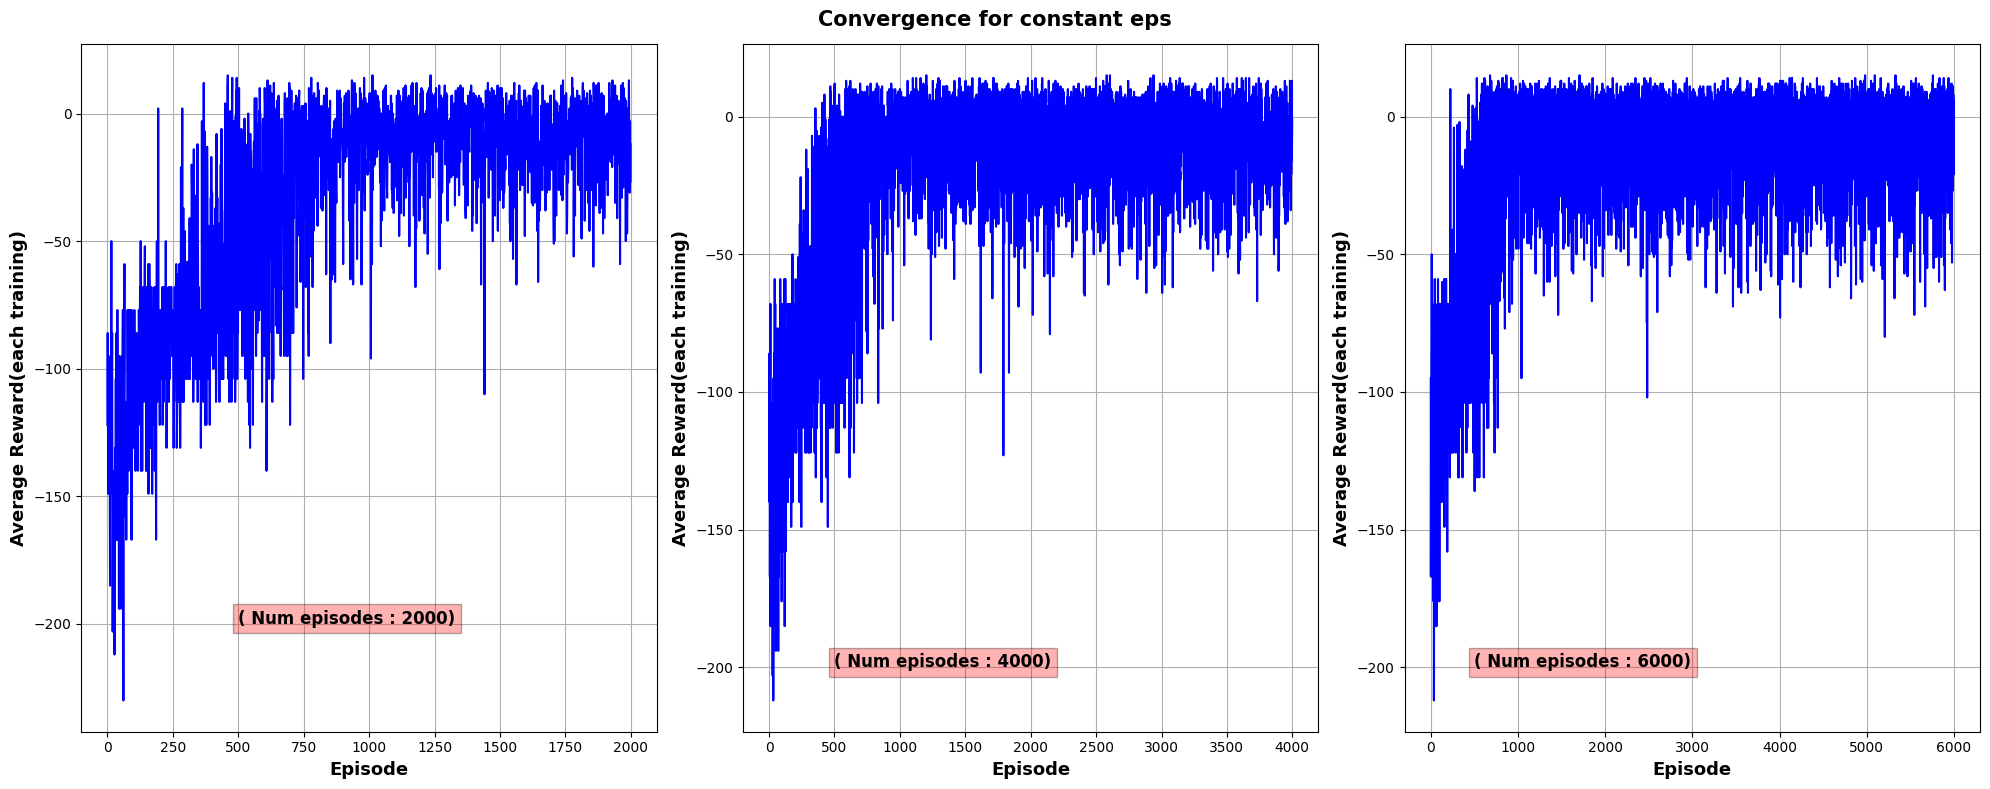

In [59]:
fig , ax = plt.subplots(1,3,figsize = (20,8))
ax = ax.flatten()
fig.suptitle('Convergence for constant eps', fontsize=15,fontweight="bold")
ax[0].plot(episod_cst_epscheck[0],rewardss_cst_epscheck[0],'b-')
ax[1].plot(episod_cst_epscheck[1],rewardss_cst_epscheck[1],'b-')
ax[2].plot(episod_cst_epscheck[2],rewardss_cst_epscheck[2],'b-')

ax[0].text(500, -200,"( Num episodes : 2000)",fontweight="bold", fontsize=12,bbox = bbox)
ax[1].text(500, -200,"( Num episodes : 4000)",fontweight="bold", fontsize=12, bbox=bbox)
ax[2].text(500, -200,"( Num episodes : 6000)",fontweight="bold", fontsize=12, bbox=bbox)

fig.subplots_adjust(hspace=0.4, top=0.9)

axes = [0,1,2]
for item in axes:
    ax[item].set_xlabel('Episode',fontdict = fontdict)
    ax[item].set_ylabel('Average Reward(each training)',fontdict = fontdict)

plt.show()

### Number of eisodes for decaying learning rate

In [26]:
                #QL_decay_lr(alpha,gamma,epsilon,min_alpha,decay_rate,num_episodes,max_steps_per_episode):

num_episodes_dc_lr = [2500,5000,10000]

reward_dclr_episodcheck = []
episode_dclr_episodcheck = []

for item in num_episodes_dc_lr:
    Q_df_dclr_episodcheck,frames_dclr_episodcheck , avg_reward_dclr_episodcheck , episodes_dclr_episodcheck , rewards_dclr_episodcheck = QL_decay_lr(0.5,0.8,0.25,0.01,0.001,item,50)
    episode_dclr_episodcheck.append(episodes_dclr_episodcheck)
    reward_dclr_episodcheck.append(rewards_dclr_episodcheck)


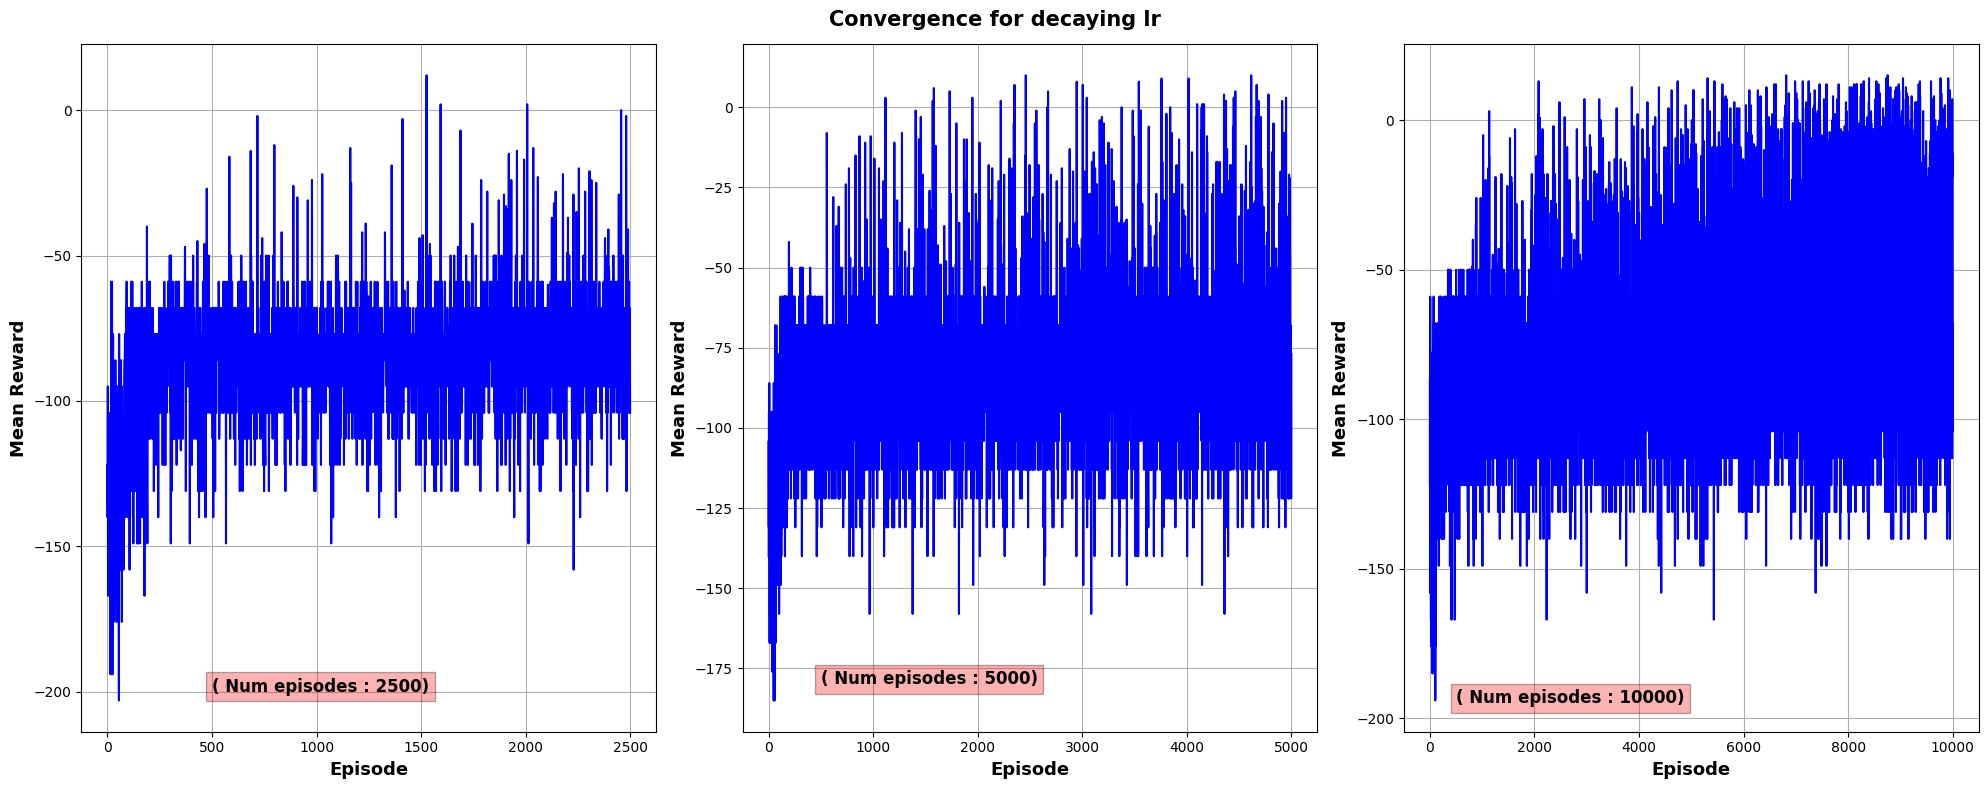

In [61]:
fig , ax = plt.subplots(1,3,figsize = (20,8))
ax = ax.flatten()
fig.suptitle('Convergence for decaying lr', fontsize=15,fontweight="bold")
ax[0].plot(episode_dclr_episodcheck[0],reward_dclr_episodcheck[0],'b-')
ax[1].plot(episode_dclr_episodcheck[1],reward_dclr_episodcheck[1],'b-')
ax[2].plot(episode_dclr_episodcheck[2],reward_dclr_episodcheck[2],'b-')

ax[0].text(500, -200,"( Num episodes : 2500)",fontweight="bold", fontsize=12,bbox = bbox)
ax[1].text(500, -180,"( Num episodes : 5000)",fontweight="bold", fontsize=12, bbox=bbox)
ax[2].text(500, -195,"( Num episodes : 10000)",fontweight="bold", fontsize=12, bbox=bbox)

fig.subplots_adjust(hspace=0.4, top=0.9)

axes = [0,1,2]
for item in axes:
    ax[item].set_xlabel('Episode',fontdict = fontdict)
    ax[item].set_ylabel('Mean Reward',fontdict = fontdict)

plt.show()

In [32]:
avg_rwd_dc_lr = np.zeros((10,))

for i in range(10):
    Q_df_dc_lr,frames_dc_lr , average_reward_dc_lr , episodes_dc_lr , rewards_dc_lr = QL_decay_lr(0.5,0.8,0.25,0.01,0.001,10000,50)
    avg_rwd_dc_lr[i] = average_reward_dc_lr
Q_df_dc_lr.to_csv(os.path.join(path,r"Q_table for Decaying learning rate.csv"))    # the last trained Q_table with 
                                                                                   #gamma: 0.8 and 
                                                                            #constant epsilon:0.25 is saved

In [33]:
avg_dc_lr_list = []
for i in range(10):
    avg_dc_lr_list.append(avg_rwd_dc_lr.mean())
    
avg_dc_eps_list_gamma_8 = []
for i in range(10):
    avg_dc_eps_list_gamma_8.append(average_np[1].mean())

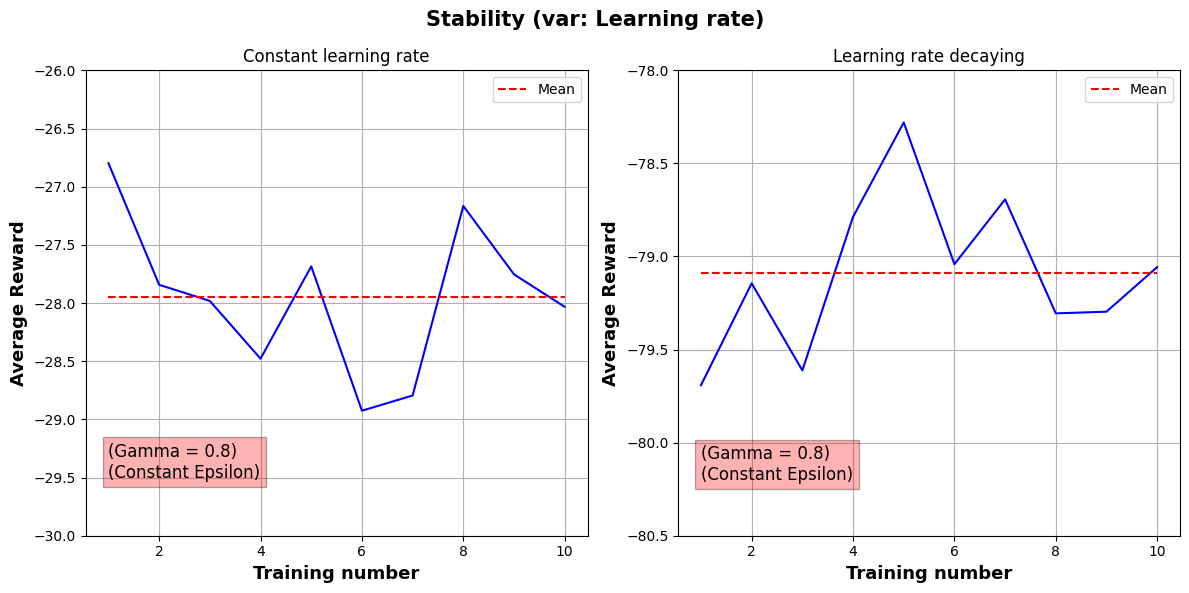


Mean Reward throughout all tries (for Constant learing rate): -11.55876
Mean Reward  throughout all tries (for decaying learning rate):-79.09083000000001


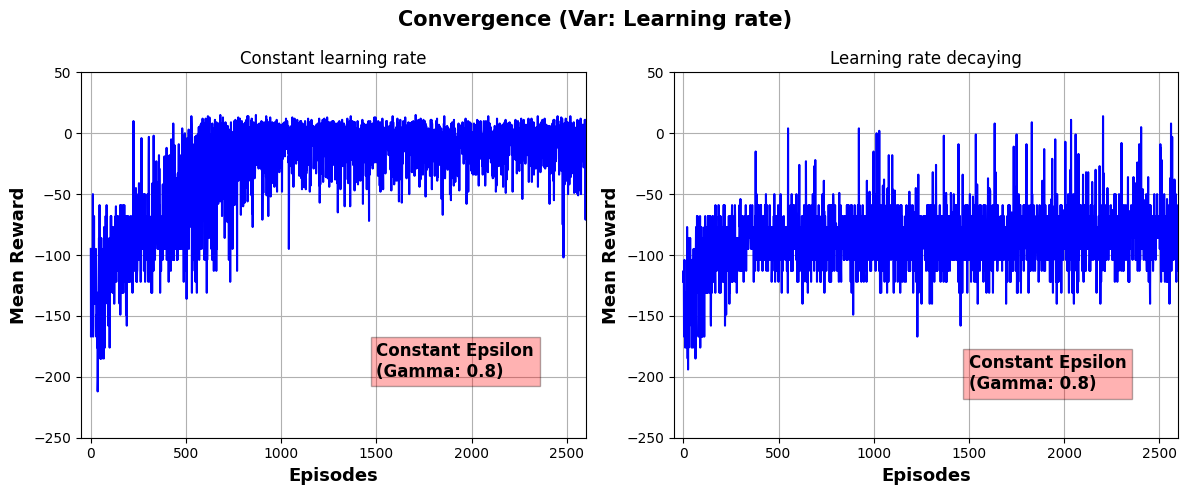

In [71]:
                                            #Stability

fig , ax = plt.subplots(1,2,figsize = (12,6))
ax = ax.flatten()
fig.suptitle('Stability (var: Learning rate)', fontsize=15,fontweight="bold")
fig.subplots_adjust(hspace=0.4, top=0.9)
ax[0].plot(X[2,:],average_cst_rwd[2],'b-')
ax[0].plot(X[2,:],avg_cst_eps_list,'r--',label = 'Mean')        # Denoting line of Mean Value 
ax[0].legend(loc = 'upper right')
ax[0].set_title('Constant learning rate')
ax[1].plot(X[1,:],avg_rwd_dc_lr,'b-')
ax[1].plot(X[1,:],avg_dc_lr_list,'r--',label = 'Mean')           # Denoting line of Mean Value 
ax[0].set_ylim([-30,-26])
ax[1].legend(loc = 'upper right')
ax[0].text(1, -29.5,"(Gamma = 0.8)\n(Constant Epsilon)", fontsize=12,bbox = bbox)
ax[1].set_title('Learning rate decaying')
ax[1].text(1, -80.2,"(Gamma = 0.8)\n(Constant Epsilon)", fontsize=12, bbox=bbox)
ax[1].set_ylim([-80.5,-78])

axes = [0,1]
for item in axes:
    ax[item].set_xlabel('Training number',fontdict = fontdict)
    ax[item].set_ylabel('Average Reward',fontdict = fontdict)

plt.show()

print(color.BOLD + f"\nMean Reward throughout all tries (for Constant learing rate): {average_np[1].mean()}")
print(f"Mean Reward  throughout all tries (for decaying learning rate):{avg_rwd_dc_lr.mean()}" + color.END)

                                            
                                            #Convergence

fig , ax = plt.subplots(1,2,figsize = (12,5))
ax = ax.flatten()
ax[0].plot(episodes_cst_eps,rewards_cst_eps,'b-')
ax[1].plot(episodes_dc_lr,rewards_dc_lr,'b-')
axes = [0, 1]
fig.suptitle('Convergence (Var: Learning rate)', fontsize=15,fontweight="bold")
fig.subplots_adjust(hspace=0.4, top=0.9)
ax[0].set_title('Constant learning rate')

ax[0].text(1500, -200,'Constant Epsilon\n(Gamma: 0.8)',fontweight="bold", fontsize=12, bbox=bbox)
ax[1].text(1500, -210,'Constant Epsilon\n(Gamma: 0.8)',fontweight="bold", fontsize=12, bbox=bbox)
ax[1].set_title('Learning rate decaying')
ax[0].set_ylim([-250,50])
ax[1].set_ylim([-250,50])

for item in axes:
    ax[item].set_xlabel('Episodes',fontdict = fontdict)
    ax[item].set_ylabel('Mean Reward',fontdict = fontdict)
    ax[item].set_xlim([-50,2600])
plt.show()

### Training Visualization ("ansi" mode rendering)

In [35]:
def print_frames(frames):
    for i , frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i+1}")
        print(f"State: {frame['state']}")
        print(f"action: {frame['action']}")
        print(f"reward: {frame['reward']}")
        sleep(0.005)

In [36]:
print_frames(frames_decay_eps)    #"ansi" mode rendering of training phase for
                                    # algorithm included decaying epsilon value policy

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 137
State: 174
action: 0
reward: -1


KeyboardInterrupt: 

## Applied (Operational) Phase

### rgb_array mode rendering

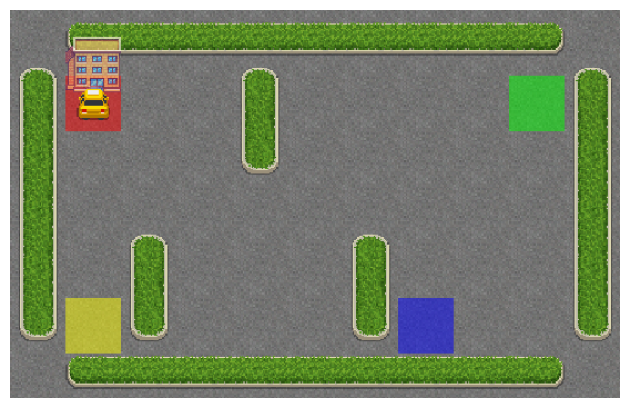

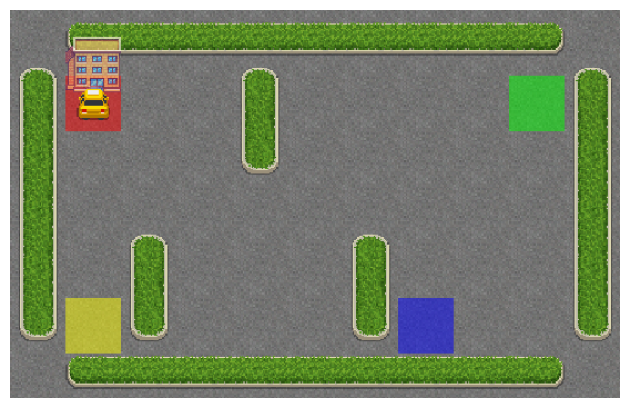

In [37]:
                            #Q_learning algorithm is taken based on Off-Policy method 
Q = Q_df_decay_eps.to_numpy()

env = gym.make('Taxi-v3',render_mode="rgb_array")
                                         #"rgb_array" mode rendering of training phase for
                                            # algorithm included decaying epsilon value policy (Gamma: 0.8, 
                                                #constant learning rate)
state_apply = env.reset()[0]
done = None 
fff = []
while done != True:
    action = np.argmax(Q[state_apply])           #In applied phase "Greedy Policy" is taken 
                                                    # We just take the action with highest Q_value
    state_apply, reward, done, _, info = env.step(action)
    #print(env.render())
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# for frame in fff:
#         clear_output(wait=True)
#         print(frame['frame'])
    

### "ansi mode rendering"

In [38]:
env = gym.make('Taxi-v3',render_mode="ansi")

state_apply = env.reset()[0]
done = None 
while done != True:
    action = np.argmax(Q[state_apply])           #In applied phase "Greedy Policy" is taken 
                                                    # We just take the action with highest Q_value
    state_apply, reward, done, _, info = env.step(action)
    print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | :